In [1]:
from pathlib import Path

from pysr import PySRRegressor

# other imports after pysr since it has to be before torch?
from jaxtyping import Float
import numpy as np
from zanj import ZANJ
import sympy as sp

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'ncols', 'dynamic_ncols', 'maxinterval', 'write_bytes', 'disable', 'ascii', 'iterable', 'miniters', 'gui', 'self', 'file', 'total', 'unit_divisor', 'unit', 'mininterval', 'postfix', 'position', 'initial', 'bar_format', 'delay', 'smoothing', 'lock_args', 'unit_scale', 'colour', 'leave', 'nrows', 'desc'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


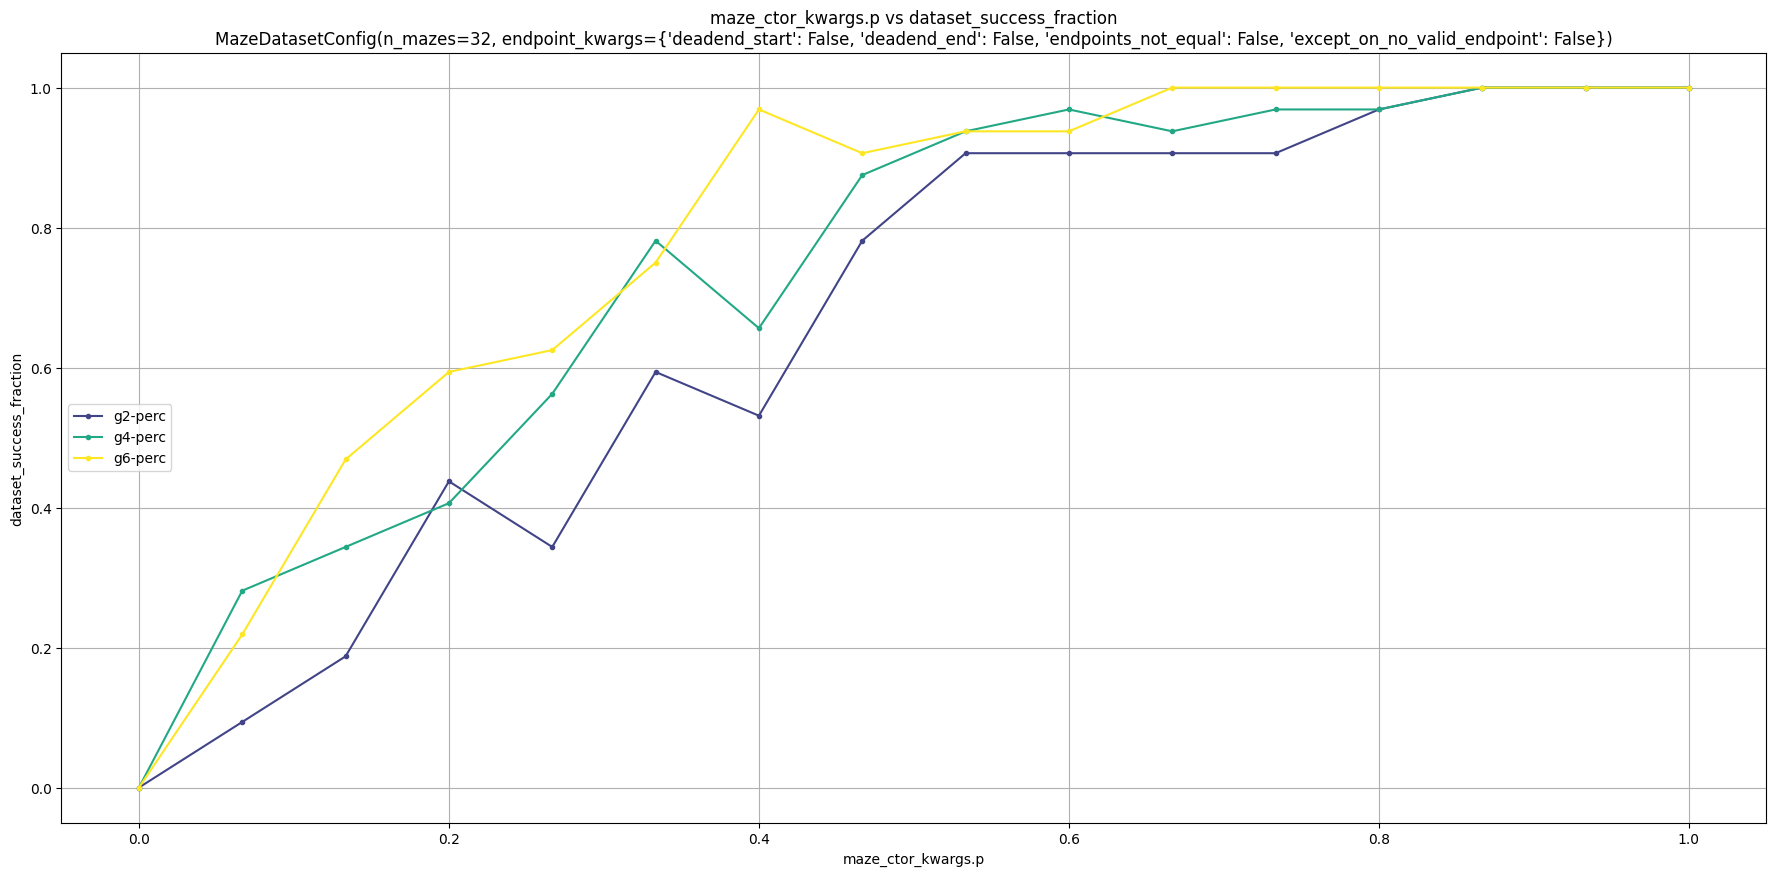

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

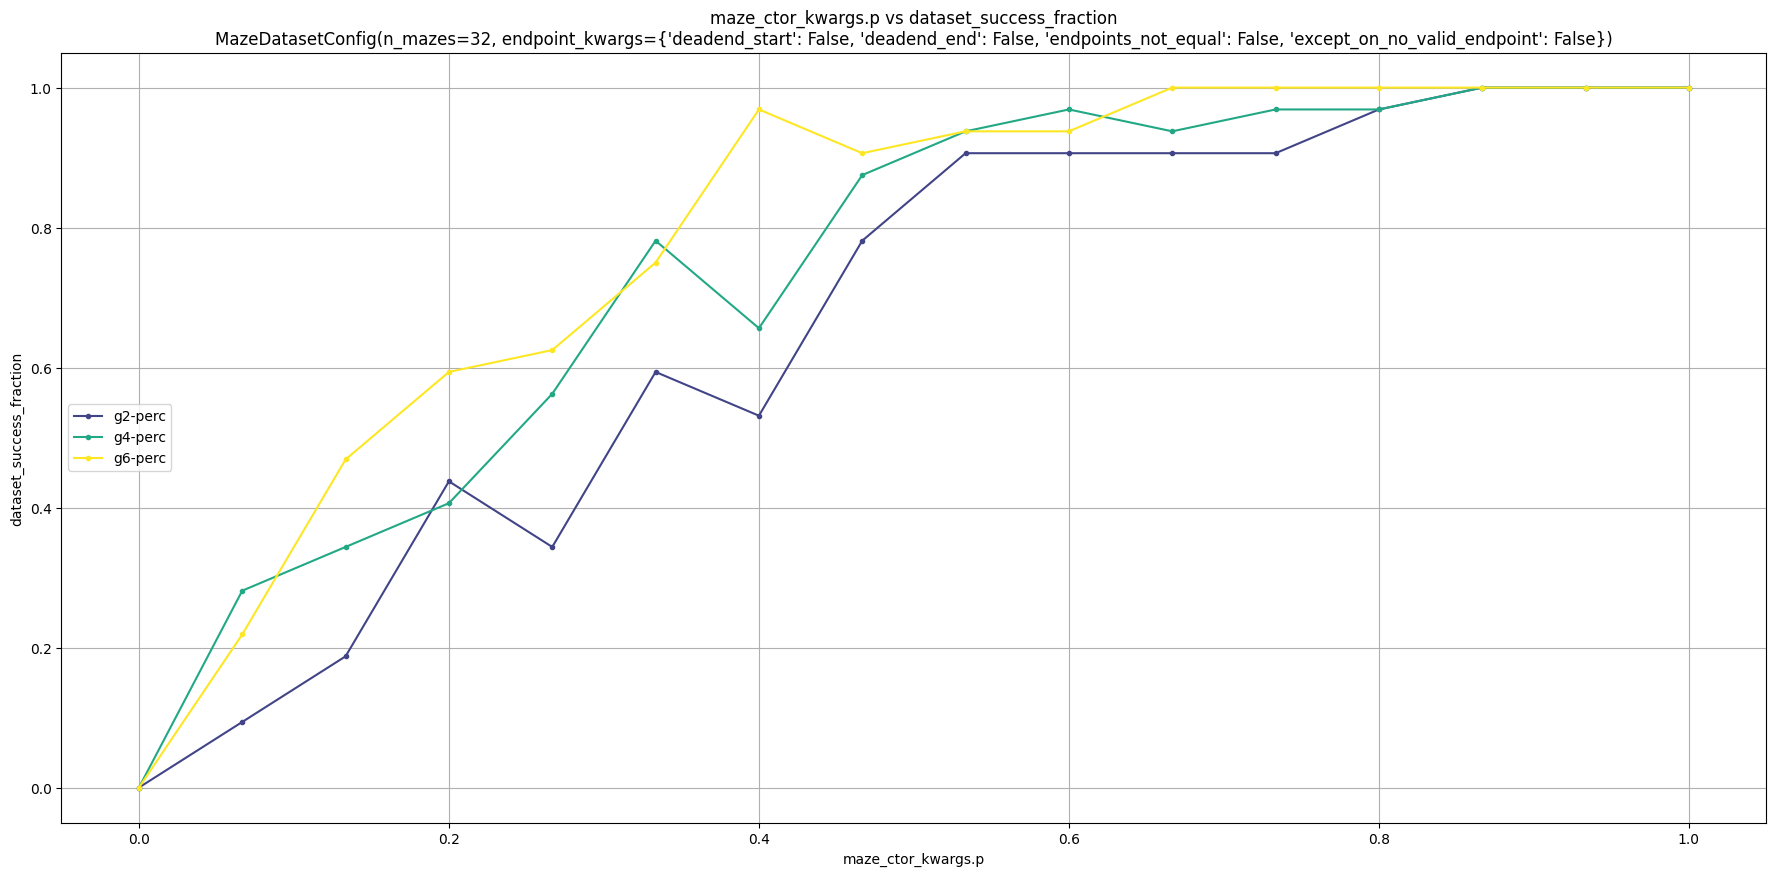

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=16,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'ncols', 'dynamic_ncols', 'maxinterval', 'write_bytes', 'disable', 'ascii', 'iterable', 'miniters', 'gui', 'self', 'file', 'total', 'unit_divisor', 'unit', 'mininterval', 'postfix', 'position', 'initial', 'bar_format', 'delay', 'smoothing', 'lock_args', 'unit_scale', 'colour', 'leave', 'nrows', 'desc'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Saving results to ../docs/benchmarks/percolation_fractions/result-n16-c18-p16.zanj


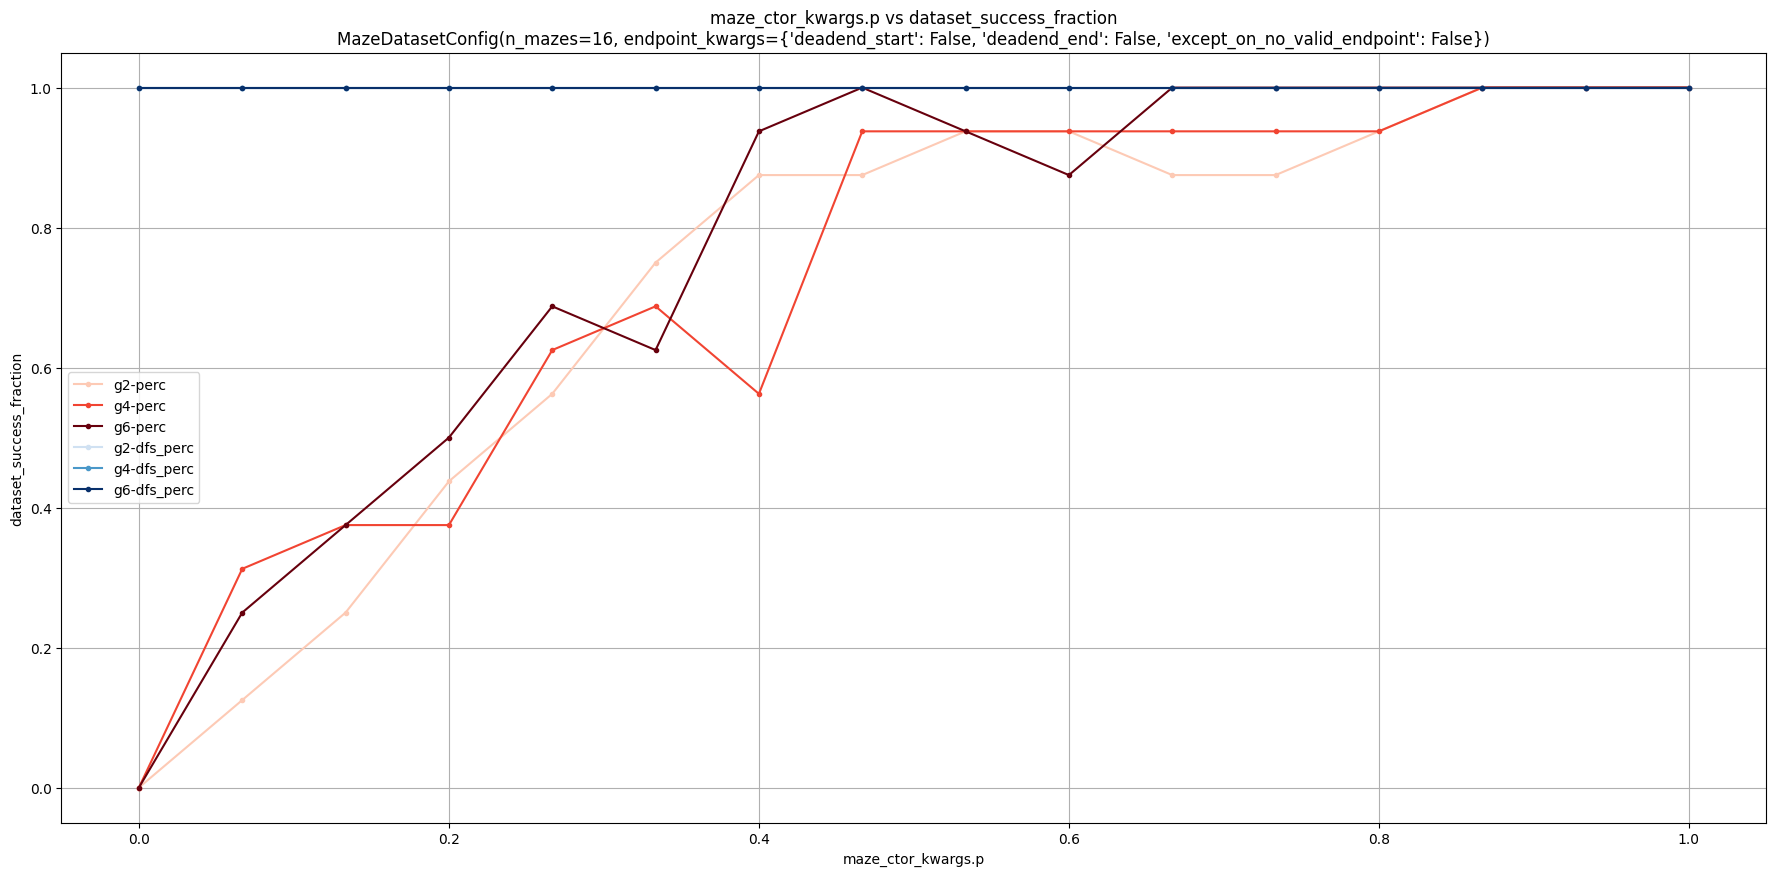

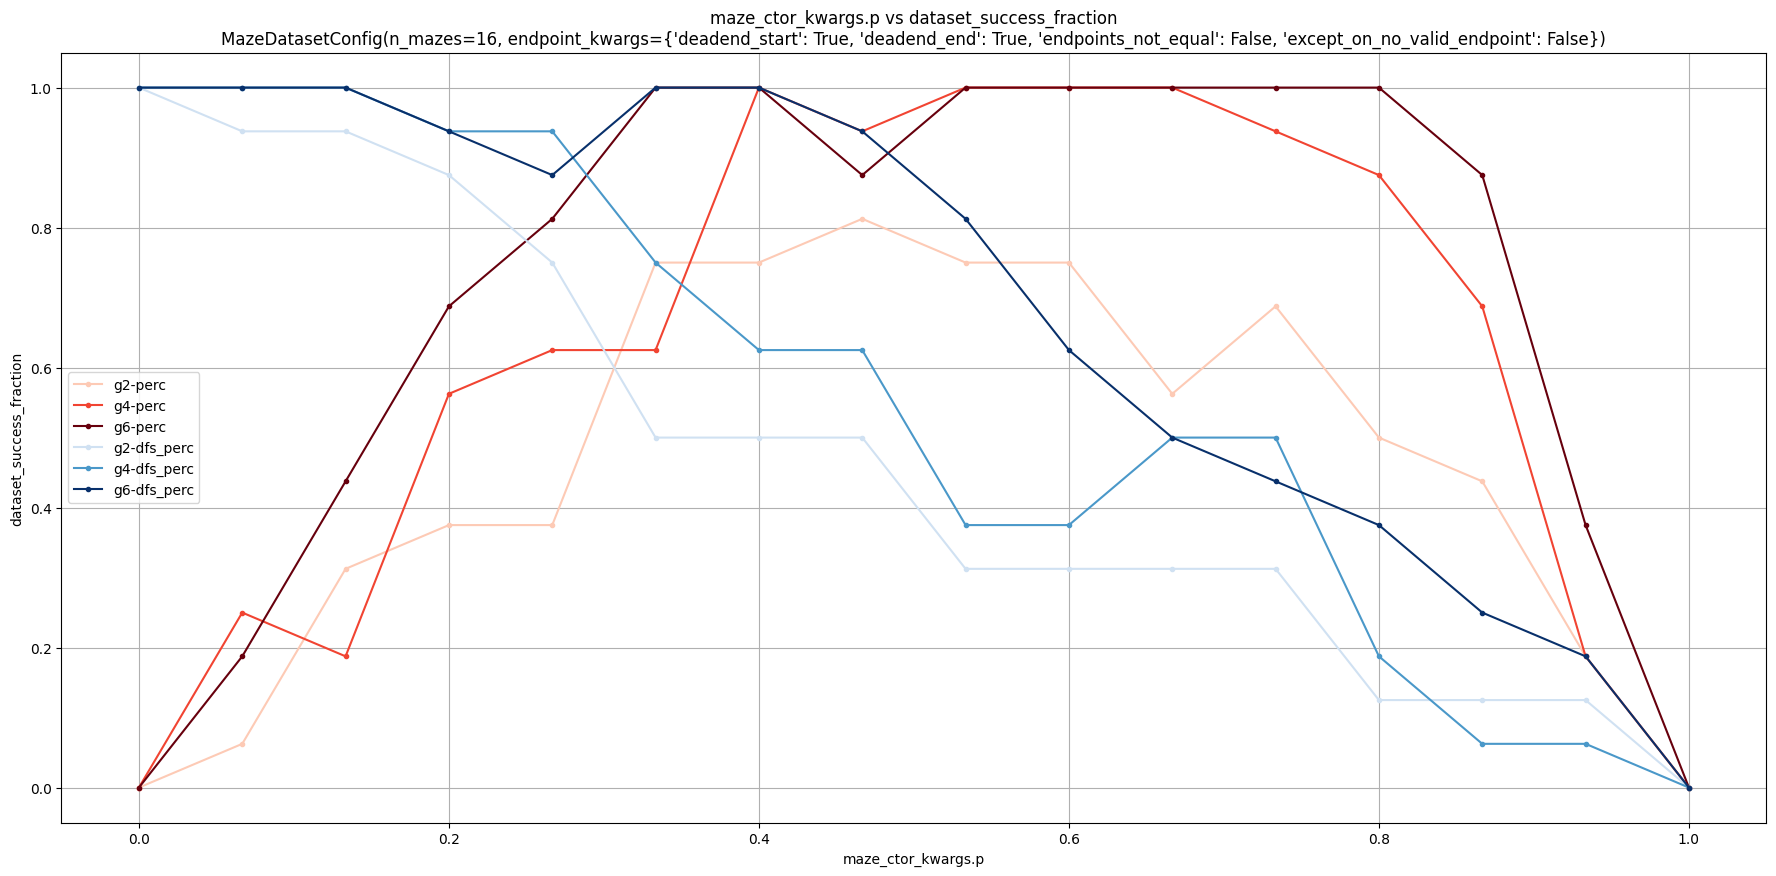

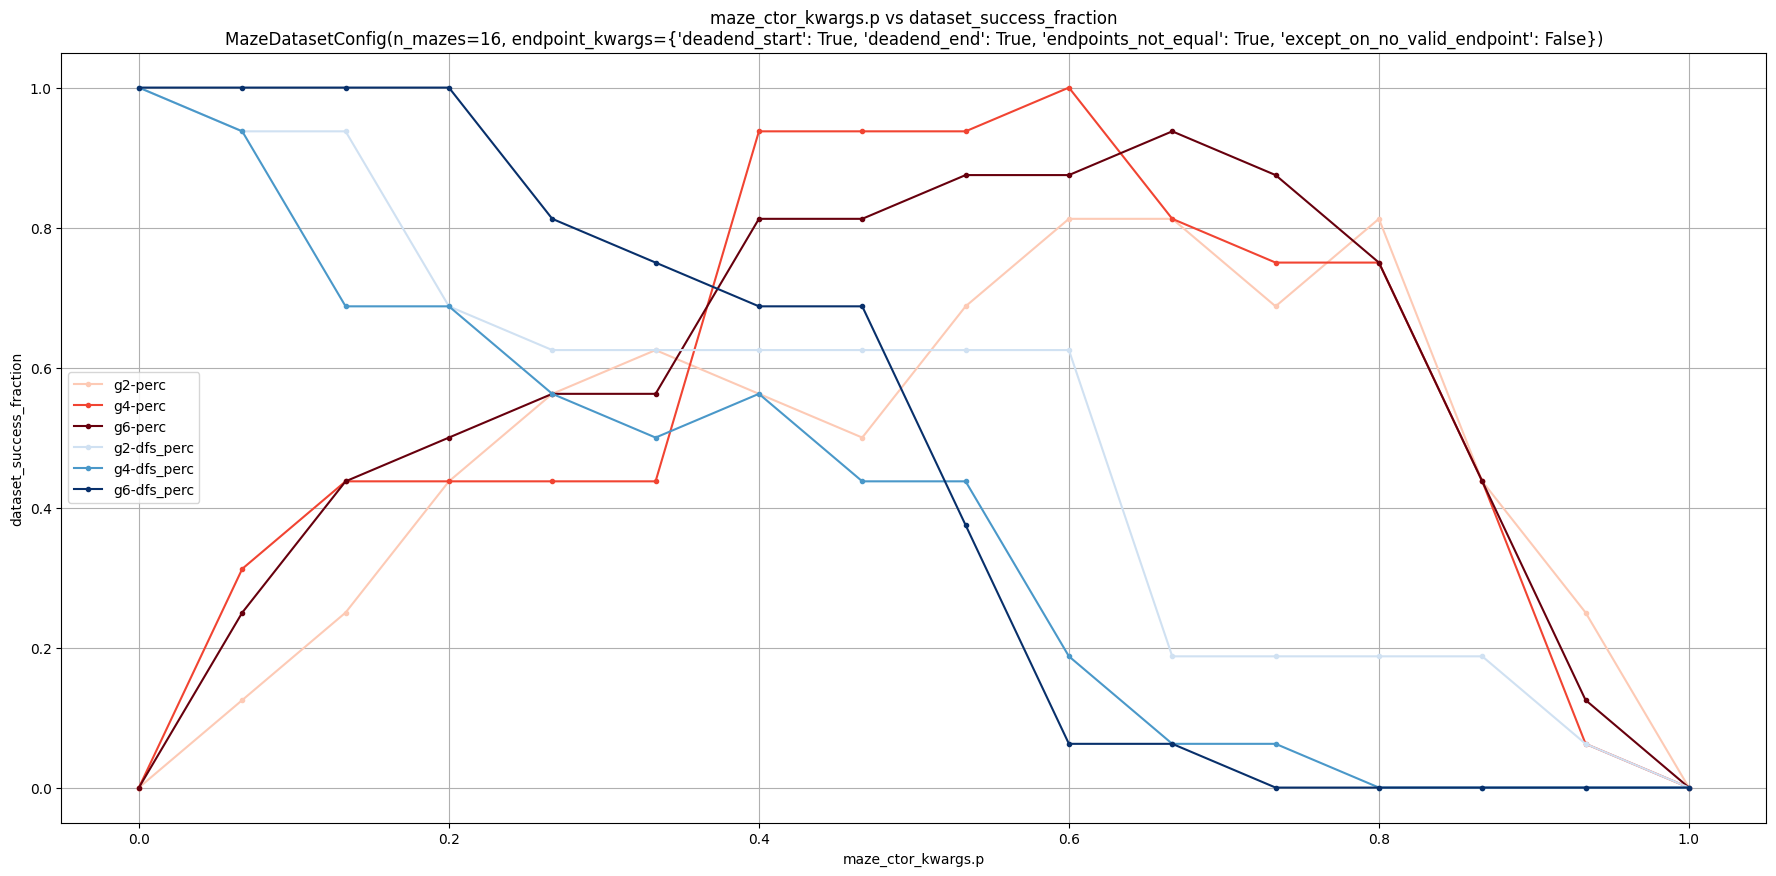

In [6]:
plot_grouped(results_full)

In [7]:
def extract_training_data(
    sweep_result: SweepResult,
) -> tuple[Float[np.ndarray, "num_rows 5"], Float[np.ndarray, " num_rows"]]:
    """Extract data (X, y) from a SweepResult.

    # Parameters:
     - `sweep_result : SweepResult`
        The sweep result holding configs and success arrays.

    # Returns:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Stacked [p, grid_n, deadends, endpoints_not_equal, generator_func] for each config & param-value
     - `y : Float[np.ndarray, "num_rows"]`
        The corresponding success rate
    """
    X_list: list[list[float]] = []
    y_list: list[float] = []
    for cfg in sweep_result.configs:
        # success_arr is an array of success rates for param_values
        success_arr = sweep_result.result_values[cfg.to_fname()]
        for i, p in enumerate(sweep_result.param_values):
            # Temporarily override p in the config's array representation:
            arr = cfg._to_ps_array().copy()
            arr[0] = p  # index 0 is 'p'
            X_list.append(arr)
            y_list.append(success_arr[i])

    return np.array(X_list, dtype=np.float64), np.array(y_list, dtype=np.float64)

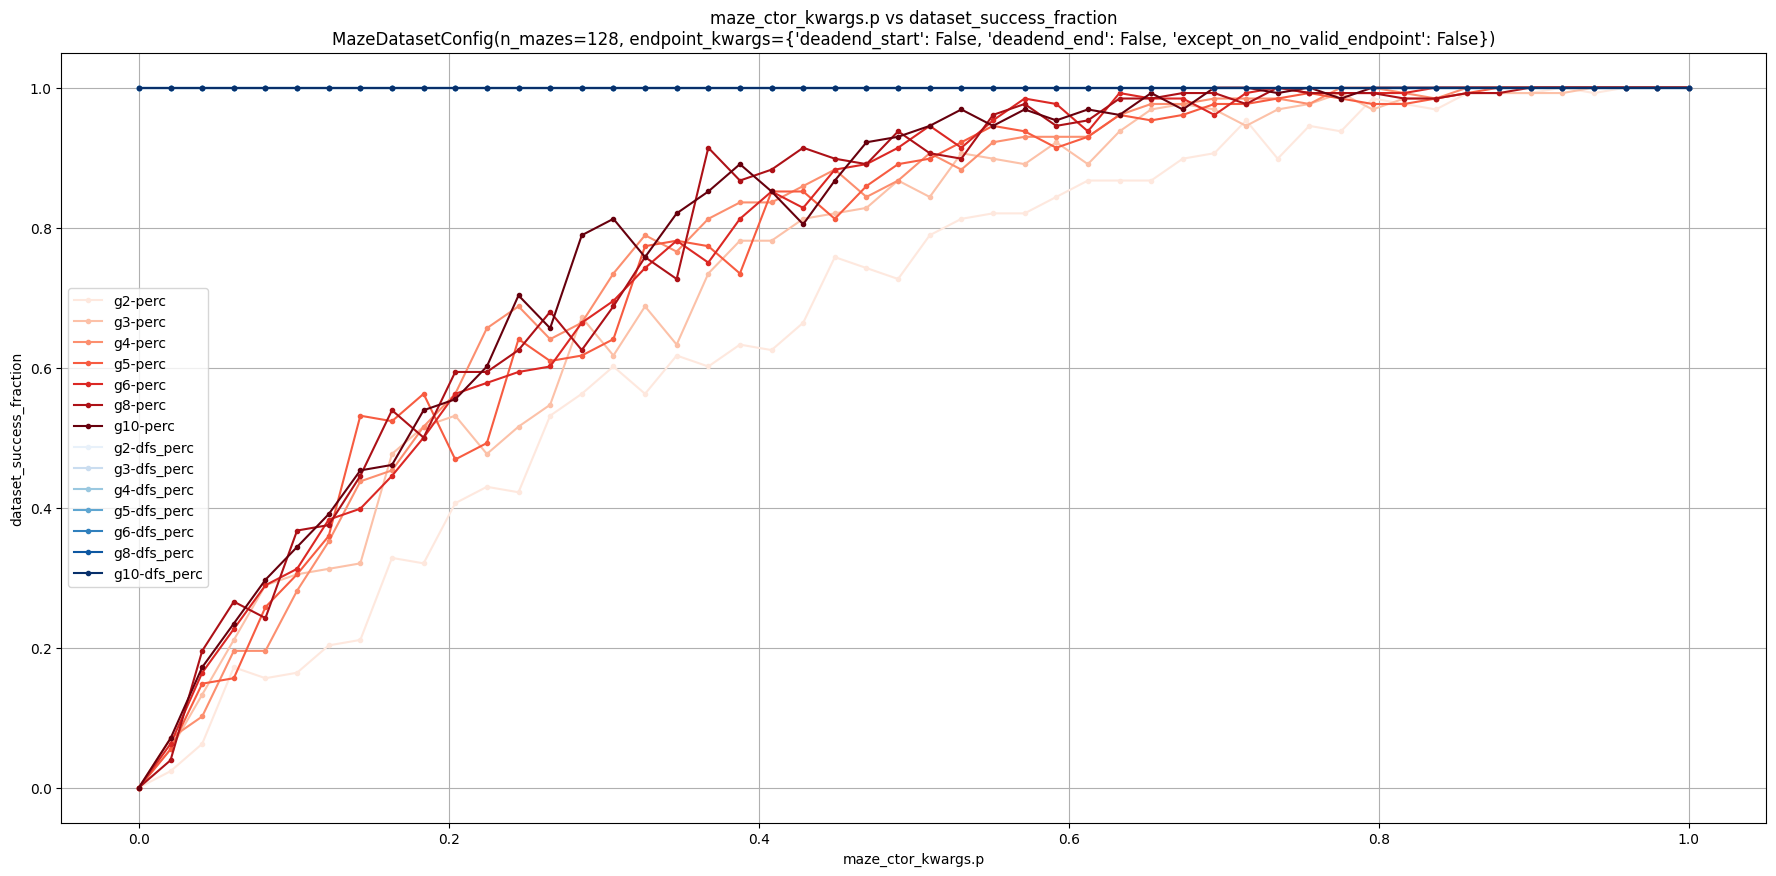

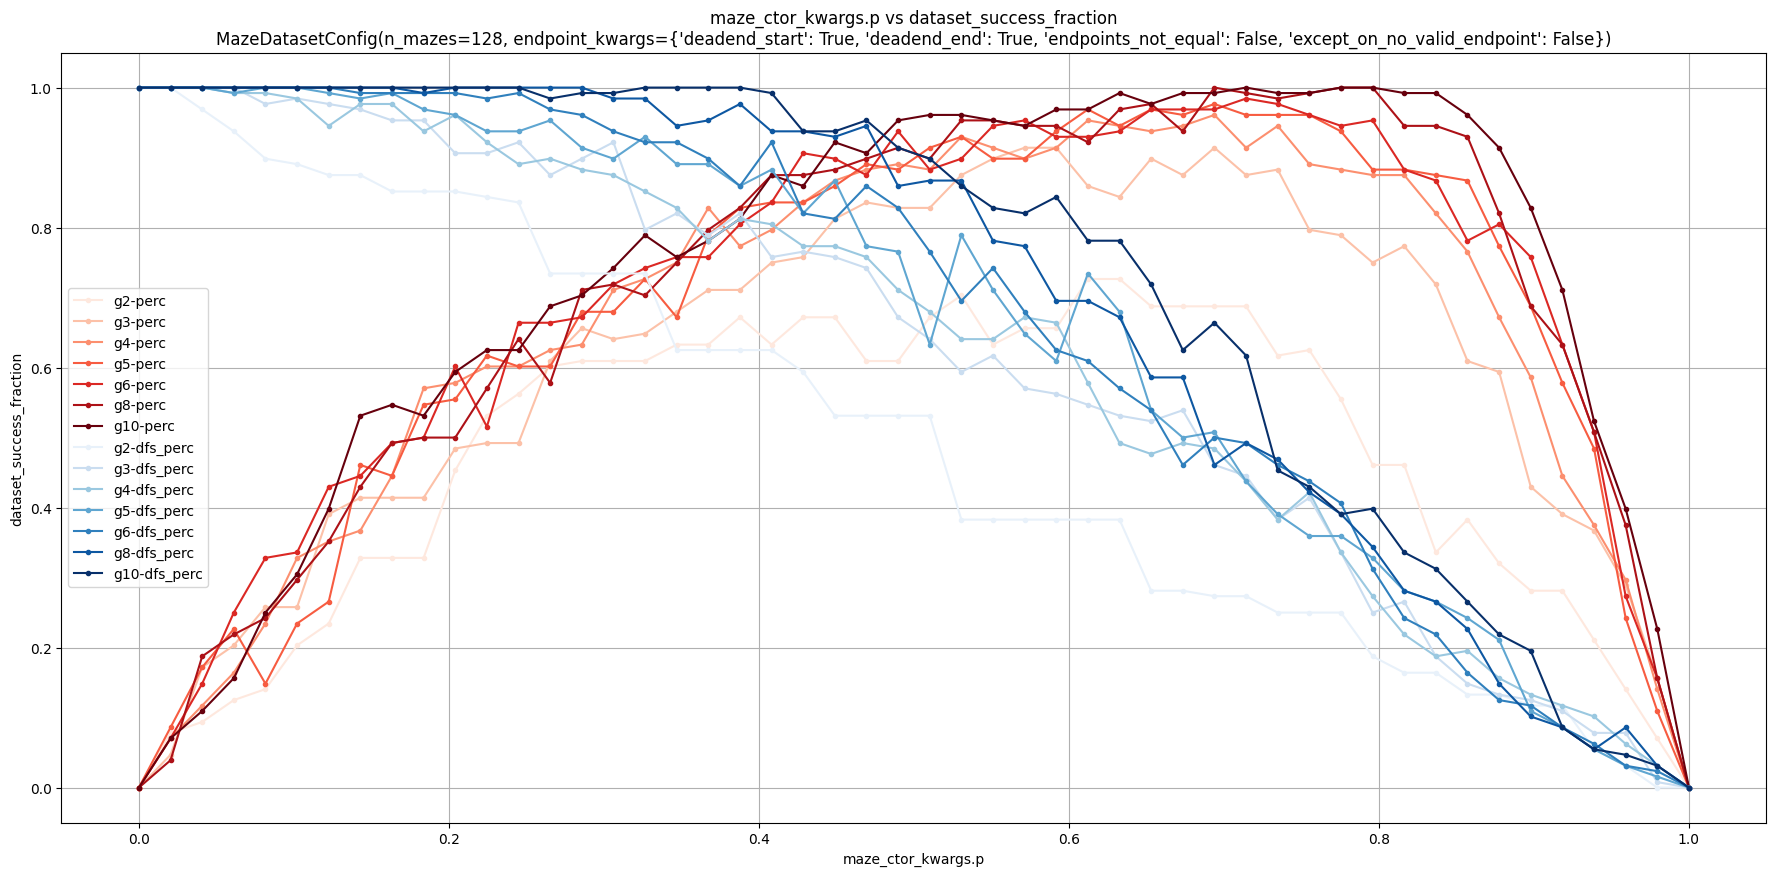

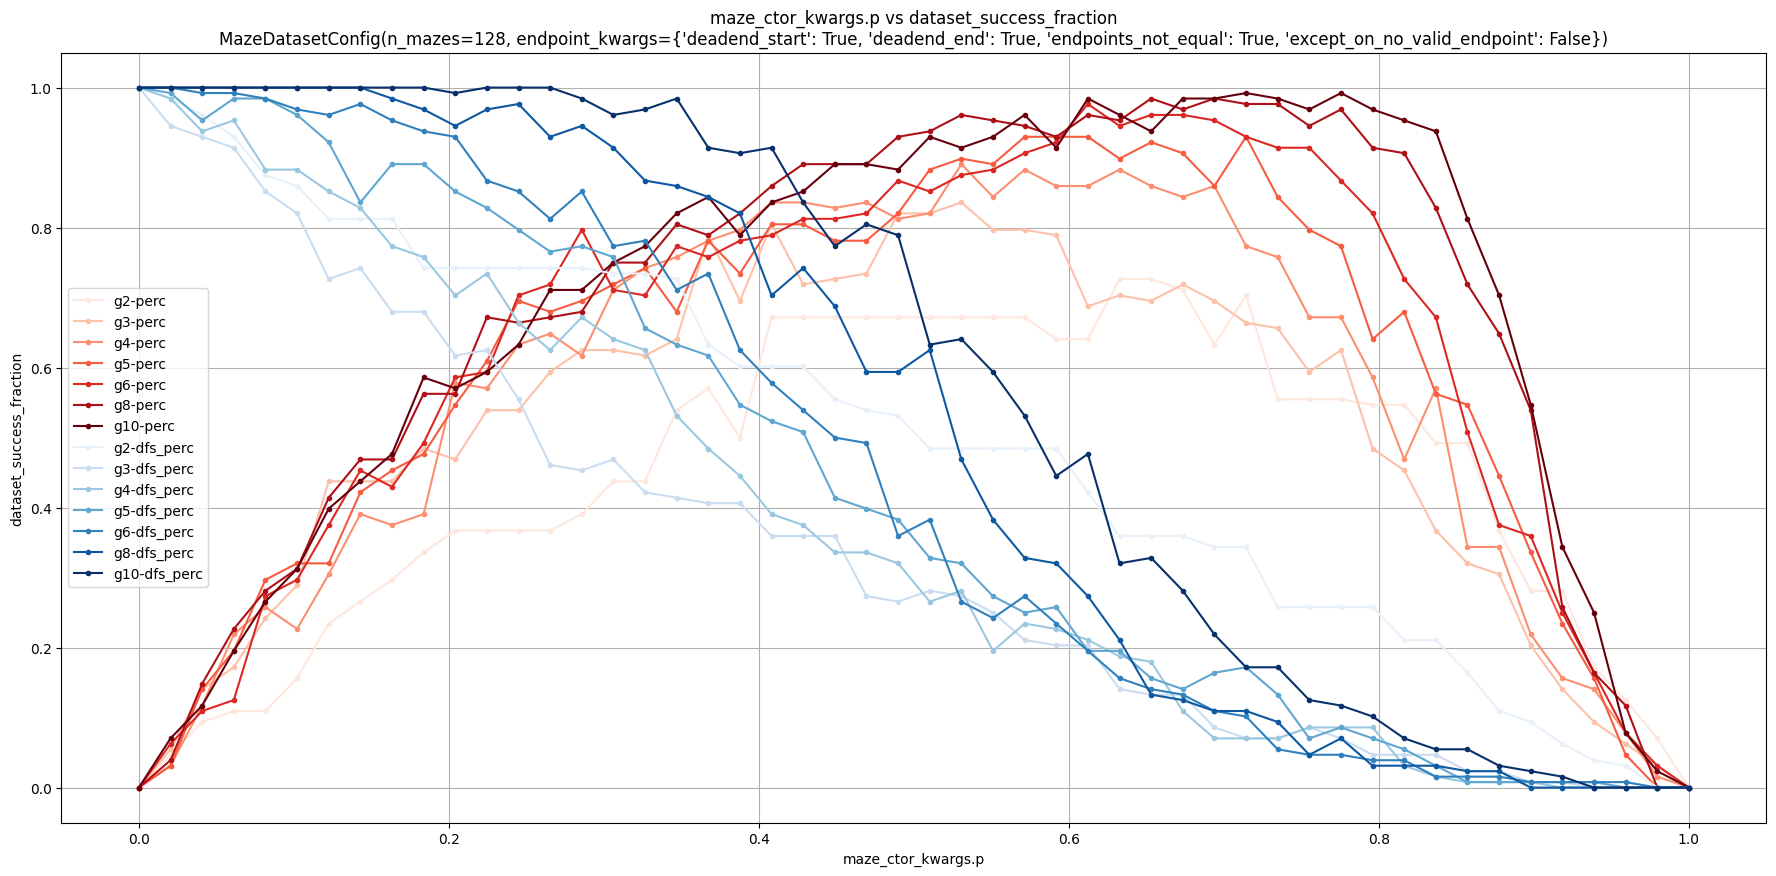

In [8]:
DATA_PATH_DIR: Path = Path("../docs/benchmarks/percolation_fractions/")
# DATA_PATH: str = DATA_PATH_DIR / "large/result-n256-c54-p100.zanj"
DATA_PATH: str = DATA_PATH_DIR / "medium/result-n128-c42-p50.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "small/result-n64-c30-p25.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "test/result-n16-c12-p16.zanj"
RESULTS_LOADED: SweepResult = SweepResult.read(DATA_PATH)


plot_grouped(RESULTS_LOADED)

In [9]:
# Convert to arrays
X, y = extract_training_data(RESULTS_LOADED)

print(f"training data extracted: {X.shape = }, {y.shape = }")

# Fit the PySR model
model = PySRRegressor(
    niterations=200,
    # Adjust operators as needed
    unary_operators=[
        "exp",
        "log",
        "square(x) = x^2",
        "cube(x) = x^3",
        "sigmoid(x) = 1/(1 + exp(-x))",
    ],
    extra_sympy_mappings={
        "square": lambda x: x**2,
        "cube": lambda x: x**3,
        "sigmoid": lambda x: 1 / (1 + sp.exp(-x)),
    },
    binary_operators=["+", "-", "*", "/"],
    # If you want advanced features, specify them here:
    # e.g. select_k_features=4, population_size=1000, etc.
    # populations=50,
    progress=True,
    model_selection="best",
)
model.fit(X, y)

training data extracted: X.shape = (2100, 5), y.shape = (2100,)
Compiling Julia backend...


f:\KNC\maze-dataset\.venv\Lib\site-packages\pysr\sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 5.130e+04
Progress: 339 / 6200 total iterations (5.468%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.119e-01  1.594e+01  y = 0.67806
3           1.116e-01  1.482e-03  y = sigmoid(sigmoid(x₃))
4           9.314e-02  1.807e-01  y = 1.3321 - sigmoid(x₂)
5           9.218e-02  1.041e-02  y = 1.1177 - square(sigmoid(x₂))
7           8.905e-02  1.727e-02  y = sigmoid(cube(1.2036 - (x₀ * x₂)))
9           7.618e-02  7.807e-02  y = sigmoid((cube(x₀ * x₂) * -3.7034) + 1.5761)
10          6.739e-02  1.225e-01  y = sigmoid(x₄ * ((x₀ * (x₂ * -5.7816)) + 2.8069))
12          4.762e-02  1.737e-01  y = sigmoid((x₄ * ((x₀ * (x₂ * -5.7816)) + 2.8069)) + x₀)
13          4.748e-02  2.900e-03  y = sigmoid((((-5.7816 * (x₀ * x₂)) + exp(x₄)) * x₄) + x₀)
14       

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.6780585   
	1         0.001482                               sigmoid(sigmoid(x3))   
	2         0.189900                           0.43099487 / sigmoid(x2)   
	3         0.001682                     (x2 * -0.29838446) + 0.8769774   
	4         0.017462                      0.39182514 / sigmoid(x0 * x2)   
	5         0.100822              (x2 * (x0 * -0.5149512)) + 0.84970564   
	6         0.086129        ((x2 * cube(x0)) * -0.7190692) + 0.80034685   
	7         0.007213     log((cube(x0) * (x2 * -1.215682)) + 2.2098393)   
	8         0.203945  sigmoid(x0 * (((x0 * -7.888713) * x2) + 5.9934...   
	9         0.064859  sigmoid((((x4 * x0) * x2) * -5.002766) + exp(x4))   
	10        0.239863  sigmoid((x0 + x4) * (((x0 * x2) * -4.0654907) ...   
	11        0.027155  sigmoid(cube((x0 + x4) * (((x0 * -3.3848553) *...   
	12        0.176490  sigmoid(x0 + ((x0 + x4) * ((x2 * (x0 * -4.3154...   
	13        0.138912  sigmoid(cube((((x2 * x0) * -3.373268) + 1.8431...   
	14        0.430046  sigmoid(((((x2 * x0) * -11.532566) + 5.2590737...   
	15        0.136039  sigmoid((log((x0 + x4) + 0.44543308) * (((x0 *...   
	16        0.170558  cube(sigmoid((x0 * 5.6952157) + (((x2 * (x0 * ...   
	17        0.035080  sigmoid(((x0 + -0.22687364) / 0.15929024) + ((...   
	18        0.334215  cube(sigmoid(((x4 + cube(x0)) * ((x2 * ((x0 * ...   
	19        0.008859  sigmoid((x0 / 0.16168195) + (((cube(x0) + x4) ...   
	20        0.045781  cube(sigmoid((x0 / 0.16757497) + ((((x0 * -11....   
	21        0.098235  cube(sigmoid((((x2 * ((x0 * -10.742241) - x3))...   
	22        0.096786  cube(sigmoid(((square(sigmoid(x1)) * x0) / 0.1...   
	23        0.110183  sigmoid((((x2 * ((x0 * -11.323293) - x3)) + 5....   
	24        0.032476  sigmoid((((x2 * ((x0 * -11.312674) - x3)) + 5....   
	25  >>>>  0.111904  sigmoid((((((x2 * x0) * -10.856927) + 4.849874...   
	26        0.015709  sigmoid((((x4 + cube(x0)) * ((((x0 * -11.29237...   
	
	        loss  complexity  
	0   0.111924           1  
	1   0.111592           3  
	2   0.092292           4  
	3   0.092137           5  
	4   0.090542           6  
	5   0.081858           7  
	6   0.075103           8  
	7   0.074563           9  
	8   0.060807          10  
	9   0.056988          11  
	10  0.044835          12  
	11  0.043633          13  
	12  0.036574          14  
	13  0.031830          15  
	14  0.020705          16  
	15  0.018072          17  
	16  0.015238          18  
	17  0.014713          19  
	18  0.010533          20  
	19  0.010440          21  
	20  0.009973          22  
	21  0.009040          23  
	22  0.008206          24  
	23  0.007350          25  
	24  0.007115          26  
	25  0.006361          27  
	26  0.006069          30  
]

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

Best PySR Equation: model.get_best()['equation'] = 'sigmoid((((((x2 * x0) * -10.856927) + 4.8498745) - x3) * (x4 + cube(x0 + 0.089015625))) + (((x0 / 0.11028679) * sigmoid(log(x1))) + -1.6852055))'
predict_fn =PySRFunction(X=>1/(5.39355919488618*exp(-9.06726907184442*x0/(1 + 1/x1) - (x4 + (x0 + 0.089015625)**3)*(-10.856927*x0*x2 - x3 + 4.8498745)) + 1))
Best PySR Equation: sigmoid((((((x2 * x0) * -10.856927) + 4.8498745) - x3) * (x4 + cube(x0 + 0.089015625))) + (((x0 / 0.11028679) * sigmoid(log(x1))) + -1.6852055))
Predicted success rate for test_config: 0.7129721449901393


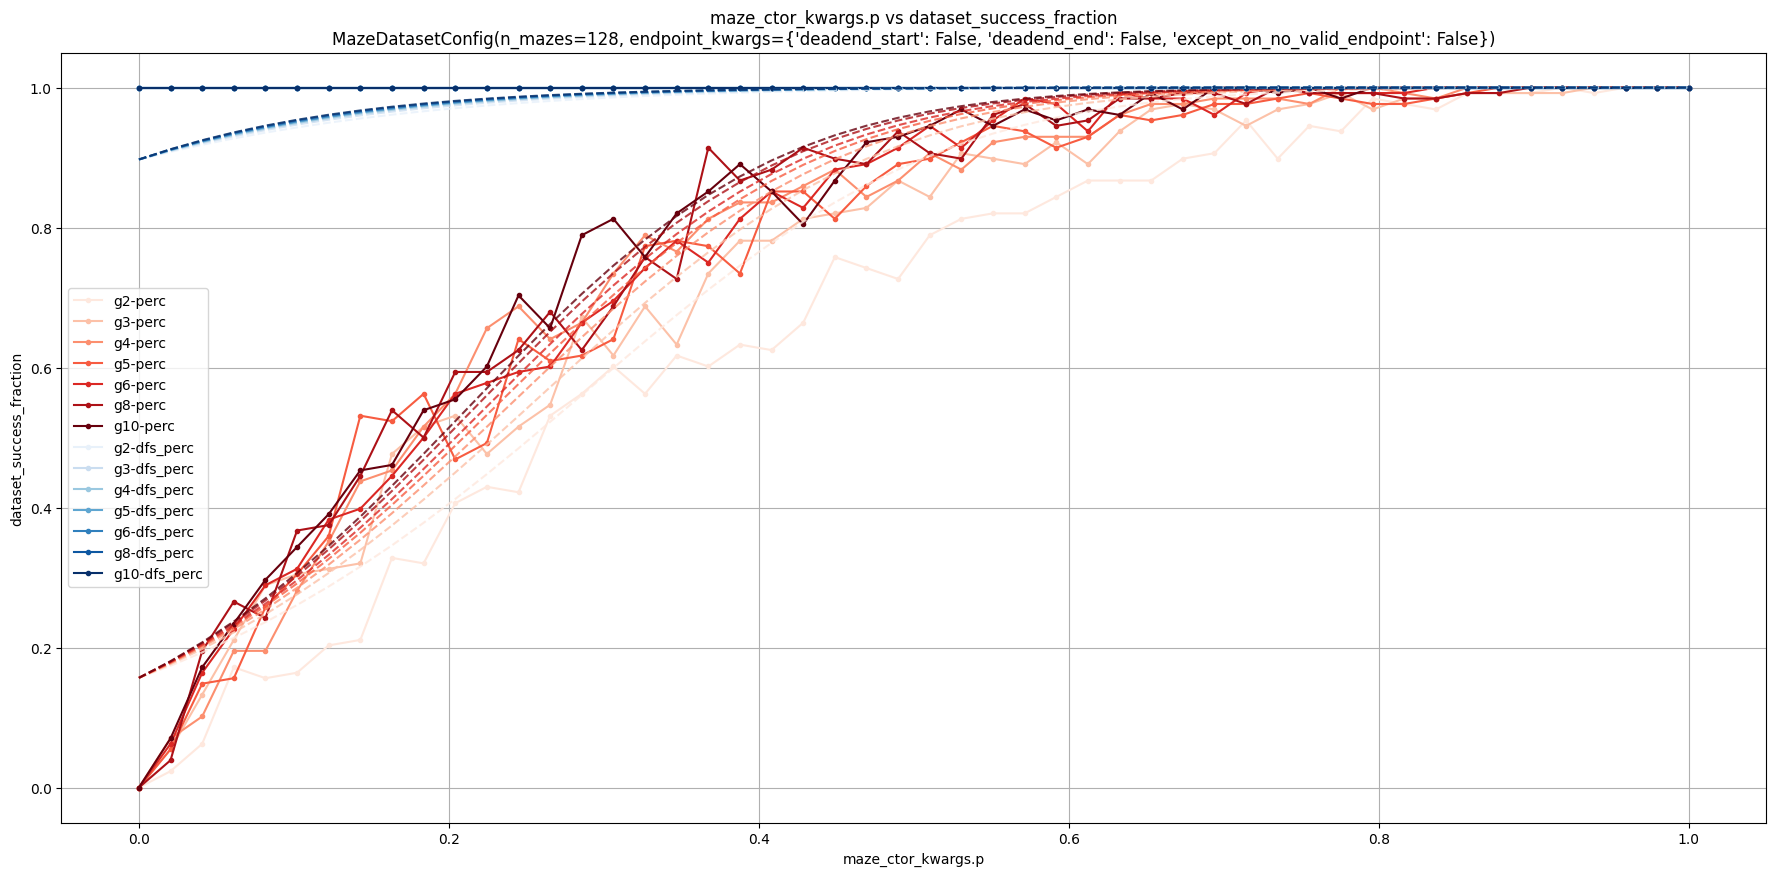

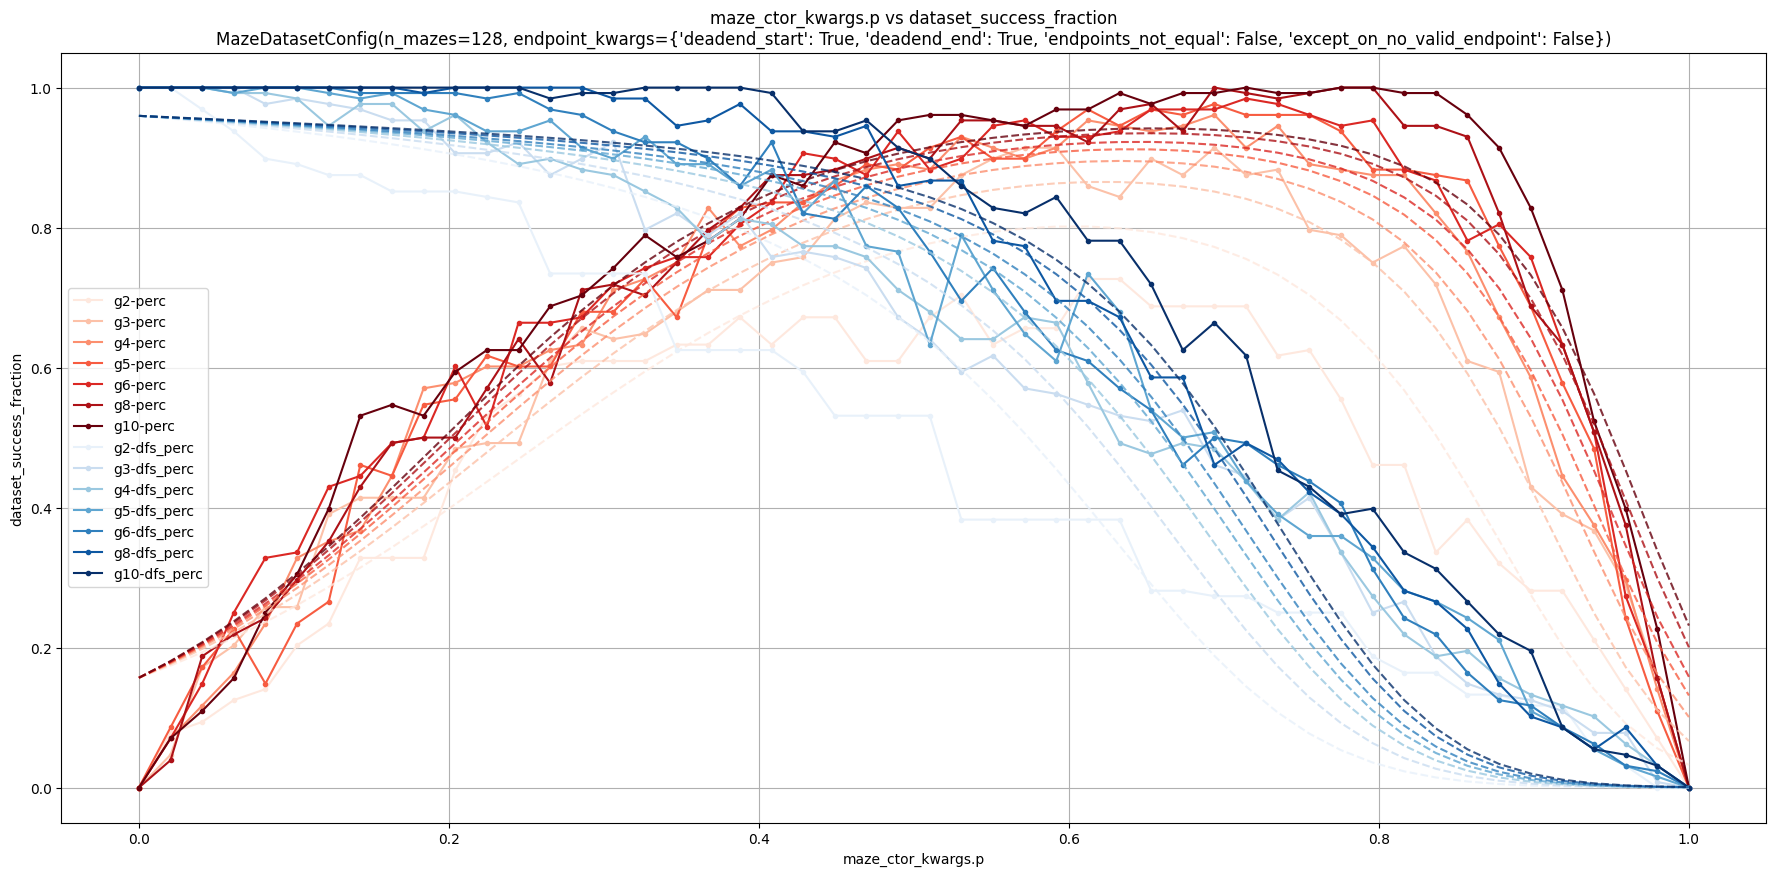

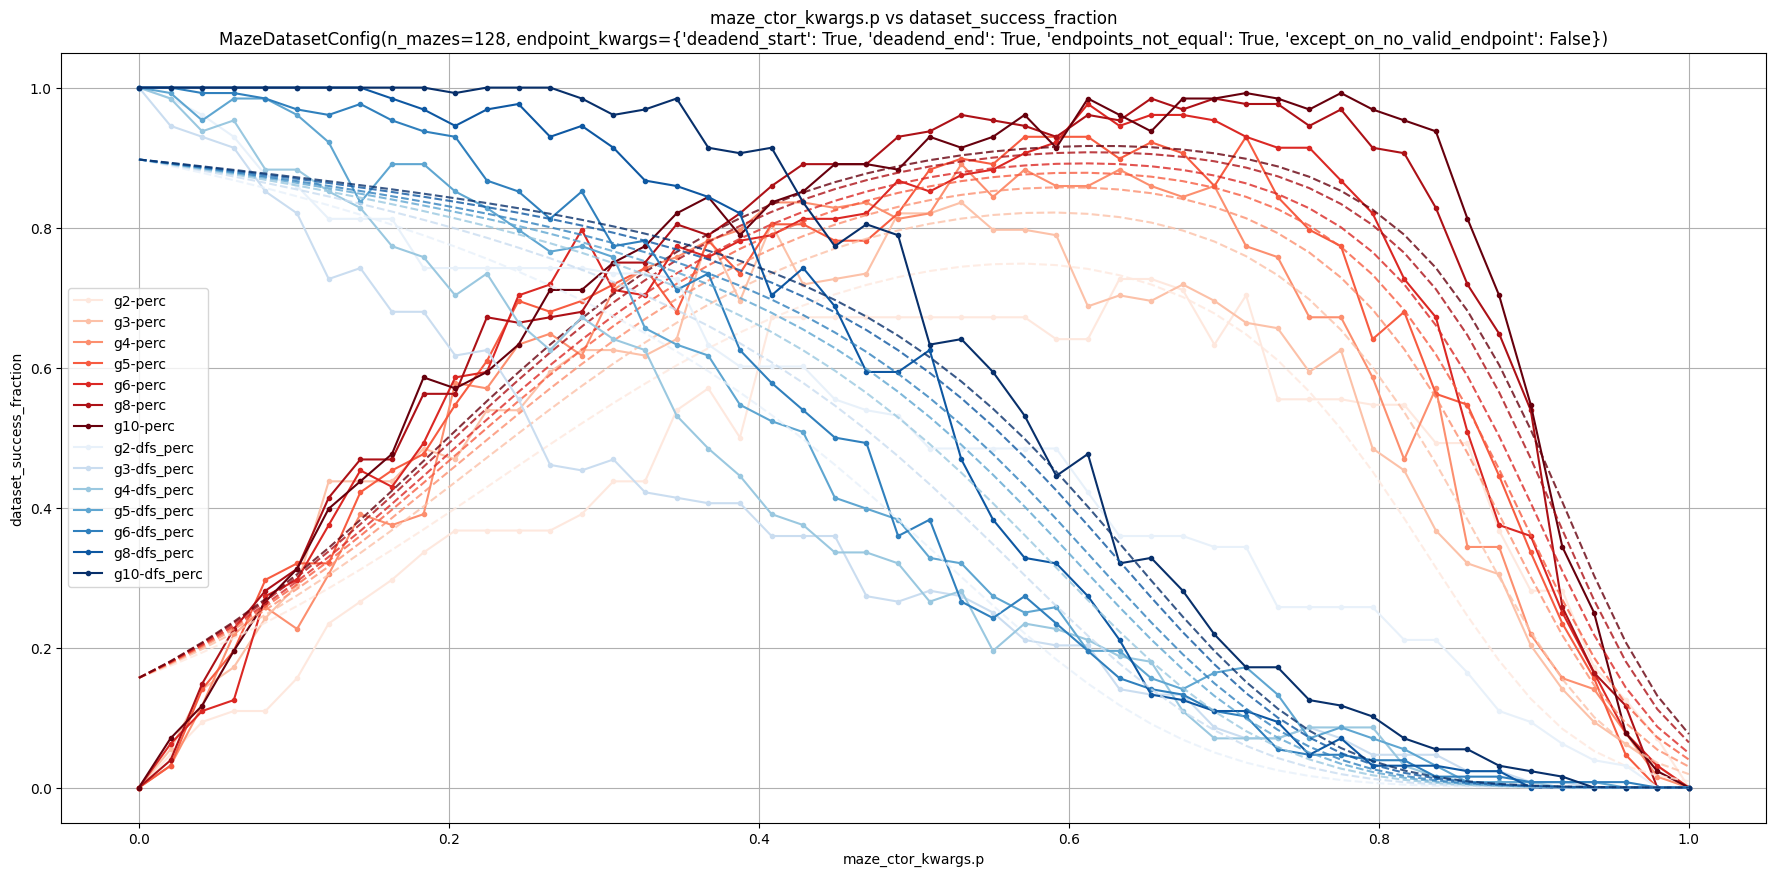

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [10]:
# Create a callable that predicts from MazeDatasetConfig
predict_fn = model.get_best()["lambda_format"]
print(f"Best PySR Equation: {model.get_best()['equation'] = }")
print(f"{predict_fn =}")


def predict_config(cfg: MazeDatasetConfig) -> float:
    arr = cfg._to_ps_array()
    result = predict_fn(arr)[0]
    return float(result)  # pass the array as separate args


# Example new config
test_config = MazeDatasetConfig(
    name="some_test",
    grid_n=16,
    n_mazes=100,
    maze_ctor=LatticeMazeGenerators.gen_percolation,
    maze_ctor_kwargs={"p": 0.3},
    endpoint_kwargs={
        "deadend_start": True,
        "deadend_end": True,
        "endpoints_not_equal": True,
        "except_on_no_valid_endpoint": False,
    },
)
predicted_rate = predict_config(test_config)
print("Best PySR Equation:", model.get_best()["equation"])
print("Predicted success rate for test_config:", predicted_rate)


plot_grouped(RESULTS_LOADED, predict_fn=predict_config)